In [1]:
using CSV
using DataFrames
using Printf
using JSON
using Statistics
using LinearAlgebra
using JLD2
using PyPlot
using FileIO
include("recsys_funcs.jl")

missing_mean (generic function with 1 method)

## fake data

create a fake $H$ matrix that obeys a known factorization

In [2]:
n_m = 200
n_g = 150
r = 2
M = randn(r, n_m)
G = randn(r, n_g)
γ = randn(1, n_g)
μ = randn(1, n_m)
h̄ = 0.6

H_truth = M' * G .+ γ .+ μ' .+ h̄

200×150 Array{Float64,2}:
  0.387229   -1.27776    -0.0586096  …   1.4473     -0.4017     -2.59249 
 -0.716602   -2.2901     -0.503136       0.535576   -0.496701   -3.94208 
  0.409093   -1.79231    -0.0799361      1.34026    -0.563453   -3.92287 
  0.178162   -0.81951     1.80417        1.92521     2.64362    -2.59399 
  0.228694   -1.3587     -0.374401       1.26475    -0.778833   -2.43596 
 -1.61439    -0.762065    1.85149    …   1.01846     4.01968    -0.958496
 -2.53815    -1.10578     0.735127       0.171645    2.93565    -0.24518 
 -3.57269    -2.3372     -0.782962      -1.03225     1.13245    -1.43428 
 -1.84193    -2.55463     1.11235        0.31422     2.67826    -4.84951 
 -0.568529   -0.0328728   0.493419       1.36758     1.39092     1.02701 
 -1.68529    -1.25085     0.99916    …   0.652013    2.68451    -1.53642 
  1.32034    -0.313674    0.951167       2.40721     0.653226   -1.6355  
 -6.18055    -3.06873     0.586965      -2.19066     4.90462    -2.10833 
  ⋮         

mask missing values

In [3]:
idx_missing = [rand(1:4) for i = 1:n_m, j = 1:n_g] .== 1
H = deepcopy(H_truth)
H = convert(Array{Union{Float64, Missing}}, H)
# H = copy(H_truth)
# [missing for i = 1:n_m, j = 1:n_g]
H[idx_missing] .= missing
H

200×150 Array{Union{Missing, Float64},2}:
   missing  -1.27776    -0.0586096  …   1.4473     -0.4017       missing
 -0.716602  -2.2901     -0.503136       0.535576   -0.496701   -3.94208 
  0.409093  -1.79231    -0.0799361      1.34026    -0.563453   -3.92287 
  0.178162  -0.81951     1.80417         missing    2.64362      missing
  0.228694  -1.3587     -0.374401       1.26475    -0.778833   -2.43596 
 -1.61439     missing    1.85149    …   1.01846     4.01968    -0.958496
 -2.53815     missing    0.735127        missing    2.93565    -0.24518 
   missing  -2.3372       missing      -1.03225     1.13245    -1.43428 
 -1.84193     missing    1.11235        0.31422     2.67826      missing
 -0.568529  -0.0328728    missing       1.36758      missing    1.02701 
 -1.68529   -1.25085     0.99916    …    missing    2.68451    -1.53642 
  1.32034   -0.313674     missing       2.40721     0.653226   -1.6355  
 -6.18055     missing    0.586965      -2.19066     4.90462    -2.10833 
  ⋮      

In [4]:
λ₁ = 1000.0
λ₂ = 1000.0

M_p, G_p, μ_p, γ_p, h̄_p, train_rmses, losses = ALS(H, r, [λ₁, λ₂], 
    min_als_sweeps=50, verbose=true, max_als_sweeps=100)

H_predicted = M_p' * G_p .+ h̄_p .+ μ_p' .+ γ_p

M shape: (2, 200)	G shape: (2, 150)
ALS sweep 10
	training loss = 2653.239868095138
	training RMSE = 0.0872460430581392
ALS sweep 20
	training loss = 2621.4498529489483
	training RMSE = 0.08692243371586647
ALS sweep 30
	training loss = 2613.057277026051
	training RMSE = 0.08698832196103291
ALS sweep 40
	training loss = 2610.6865678417475
	training RMSE = 0.08690875782778223
ALS sweep 50
	training loss = 2610.0447221670156
	training RMSE = 0.08693147999478523
ALS sweep 60
	training loss = 2609.846555568697
	training RMSE = 0.08693585566455206
loss stopped decreasing


200×150 Array{Float64,2}:
  0.3934     -1.19784    -0.0431773  …   1.41387   -0.379749  -2.42518 
 -0.662765   -2.16487    -0.4638         0.540082  -0.462352  -3.718   
  0.425087   -1.70124    -0.0648527      1.3135    -0.548752  -3.72938 
  0.191497   -0.745859    1.74755        1.86661    2.55519   -2.40699 
  0.244438   -1.28126    -0.336881       1.24237   -0.731081  -2.29964 
 -1.52394    -0.696307    1.78789    …   0.991061   3.87174   -0.873623
 -2.41045    -1.02942     0.727118       0.18241    2.84856   -0.210411
 -3.37263    -2.20583    -0.718164      -0.950812   1.11332   -1.36909 
 -1.75265    -2.4112      1.07377        0.309272   2.57976   -4.5656  
 -0.513735   -0.0125578   0.493818       1.33932    1.35139    0.986225
 -1.60029    -1.17128     0.968883   …   0.636447   2.59137   -1.43009 
  1.29247    -0.270921    0.925604       2.33695    0.630186  -1.50562 
 -5.91212    -2.89865     0.587721      -2.09757    4.75913   -1.9811  
  ⋮                                  ⋱

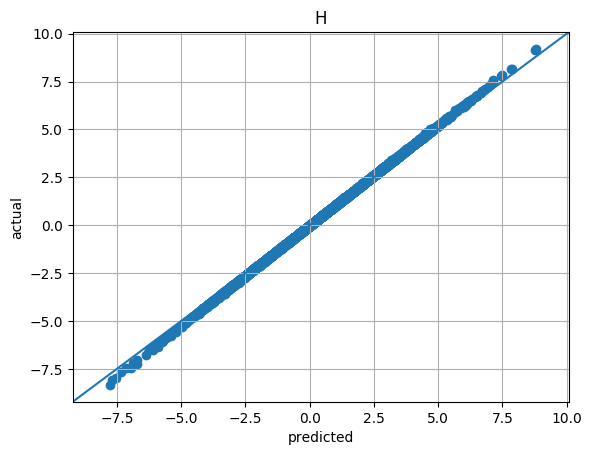

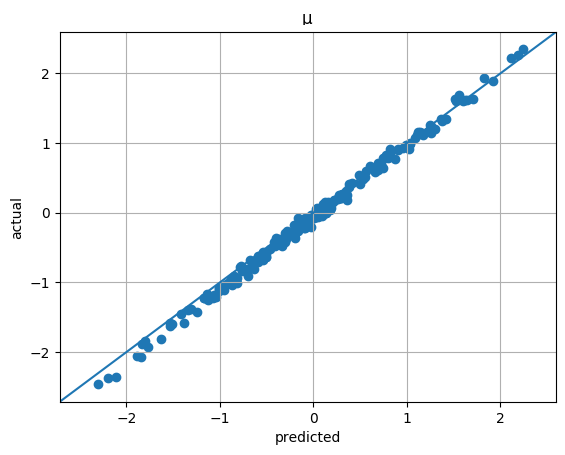

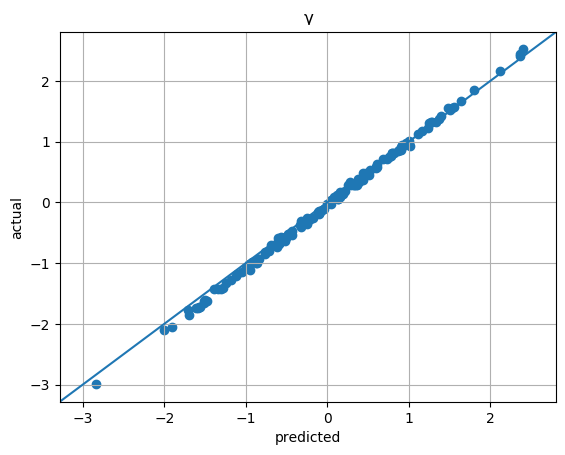

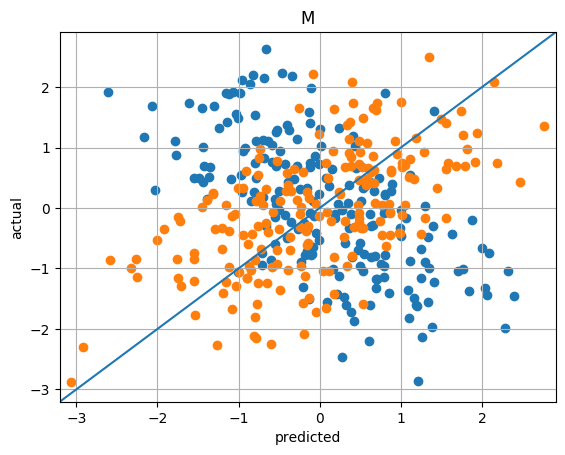

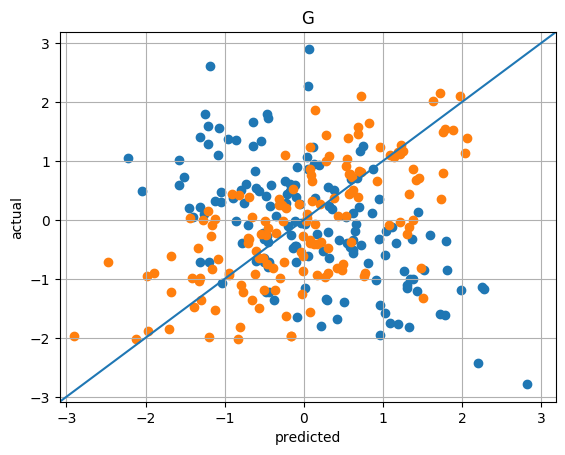

In [5]:
function mk_diagonal()
    lim = ax.get_ylim()
    ax.plot(lim, lim)
    ax.set_xlim(lim)
    ax.set_ylim(lim)
end

fig, ax = plt.subplots()
plt.scatter(H_predicted[idx_missing], H_truth[idx_missing])
plt.grid()
xlabel("predicted")
ylabel("actual")
mk_diagonal()
ax.set_title("H")
plt.show(fig)

    
fig, ax = plt.subplots()
plt.scatter(μ_p, μ)
xlabel("predicted")
ylabel("actual")
mk_diagonal()
plt.grid()
ax.set_title("μ")
plt.show(fig)

fig, ax = plt.subplots()
plt.scatter(γ_p, γ)
xlabel("predicted")
ylabel("actual")
mk_diagonal()
plt.grid()
ax.set_title("γ")
plt.show(fig)

fig, ax = plt.subplots()
plt.scatter(M_p[1, :], M[1, :])
plt.scatter(M_p[2, :], M[2, :])
xlabel("predicted")
mk_diagonal()
ylabel("actual")
plt.grid()
ax.set_title("M")
plt.show(fig)

fig, ax = plt.subplots()
plt.scatter(G_p[1, :], G[1, :])
plt.scatter(G_p[2, :], G[2, :])
xlabel("predicted")
mk_diagonal()
ylabel("actual")
plt.grid()
ax.set_title("G")
plt.show(fig)

# real data

In [6]:
henry_df = CSV.read(joinpath("..", "data", "henry_matrix_df_l_4.csv"))
H = convert(Array{Union{Float64, Missing}, 2}, henry_df[1:end, 2:end])
log_H = log10.(H);

M shape: (2, 222)	G shape: (2, 40)
ALS sweep 10
	training loss = 742.1814004866734
	training RMSE = 0.8396376738121409
ALS sweep 20
	training loss = 742.7063511701543
	training RMSE = 0.8390076686033694
ALS sweep 30
	training loss = 742.7155521017601
	training RMSE = 0.8389959069276322
ALS sweep 40
	training loss = 742.7157488690959
	training RMSE = 0.8389956786184241
ALS sweep 

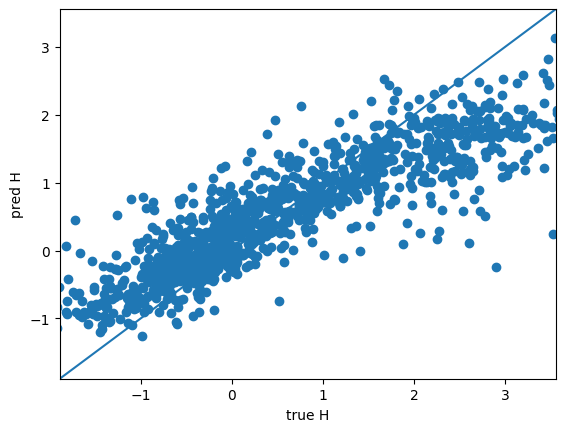

50
	training loss = 742.7157520879435
	training RMSE = 0.8389956743693838
ALS sweep 60
	training loss = 742.7157521564275
	training RMSE = 0.8389956742827007
loss stopped decreasing


(-1.886603016970615, 3.551835491377521)

In [7]:
M, G, μ, γ, h̄, train_rmses, losses = ALS(log_H, r, [λ₁, λ₂], 
    min_als_sweeps=50, verbose=true, max_als_sweeps=100)

log_H_pred = M' * G .+ γ .+ μ' .+ h̄

# should at least fit the training data!
fig, ax = plt.subplots()
scatter(log_H[.! ismissing.(log_H)], log_H_pred[.! ismissing.(log_H)])
xlabel("true H")
ylabel("pred H")
mk_diagonal()

In [19]:
test_error, log_H_pred = LOO_cross_validation(log_H, 2, 20.0, 28.0, "test_save_jld", 
    min_als_sweeps=5, max_als_sweeps=10, show_progress=true)

------------------------------
Starting LOO-ALS with the following parameters:
	r = 2, λ = [20.0000, 28.0000]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:18


Test RMSE: 0.9170


(0.9169778942303894, [-0.6103174701926333 -0.2253892129966386 … NaN NaN; 1.0282804963883765 -0.1550368432265049 … NaN NaN; … ; 0.3499201911800216 -0.5674246828651682 … NaN NaN; NaN NaN … NaN NaN])

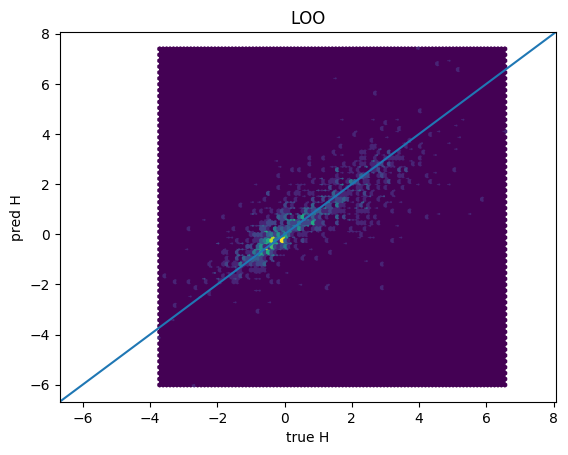

0.6355790624261903

In [20]:
# remove outliers

idx = (.! ismissing.(log_H)) .& (abs.(log_H_pred) .< 10.0)

fig, ax = plt.subplots()
hexbin(log_H[idx], log_H_pred[idx])
mk_diagonal()
xlabel("true H")
ylabel("pred H")
title("LOO")

SS_res = sum((log_H_pred[idx] .- log_H[idx]) .^ 2)
SS_tot = sum((log_H[idx] .- mean(log_H[idx])) .^ 2)

R2 = 1 - SS_res / SS_tot